In [1]:
from operator import add
from typing import List, TypedDict, Optional, Annotated, Dict


# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

#### Sub-graphs

In [3]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutput(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summar of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation"
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}


fa_builder = StateGraph(FailureAnalysisState, output_schema=FailureAnalysisOutputState)

fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

/var/folders/4w/wv1fjnjn2l5b6kzwv57x8ltw0000gn/T/ipykernel_20401/457121198.py:27: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  qs_builder = StateGraph(QuestionSummarizationState, output=QuestionSummarizationOutputState)


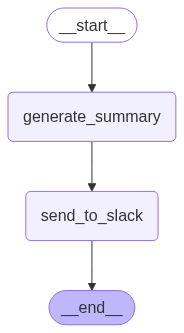

In [ ]:
# Summarization Sub-graph

class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]


def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: report = summarize(cleaned_logs)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store"
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}


qs_builder = StateGraph(QuestionSummarizationState, output=QuestionSummarizationOutputState)

qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)

qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

#### Adding sub-graphs to our parent graph

In [ ]:
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    report: str
    processed_logs: Annotated[List[int], add]

In [ ]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str   # This will be generated in the failure analysis sub-graph
    report: str       # This will be generated in the question summarization sub-graph
    processed_logs: Annotated[List[int], add]  # This will be generated in both sub-graphs


def clean_logs(state):
    """Clean the logs"""
    raw_logs = state["raw_logs"]
    # DAta cleaning raw_logs -> docs
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}


entry_builder = StateGraph(EntryGraphState)

entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("question_summarization", END)
entry_builder.add_edge("failure_analysis", END)

graph = entry_builder.compile()
# xray=1 will show the internal structure of the nested graphs
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

KeyboardInterrupt: 

In [ ]:
# Dummy logs

question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="You can import ChatOllama by using the import statement in your Python code.",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="You can use Chroma vector store by using the Chroma class in your Python code.",
    grade=0,
    grader="John Doe",
    feedback="The answer is not correct.",
)

raw_logs = [question_answer, question_answer_feedback]

graph.invoke({"raw_logs": raw_logs})